In [1]:
import numpy as np
import pandas as pd
import scipy.special as spsp
import scipy.stats as spst
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

# Setting

We have a dataset tracking the status of 3200 heterosexual couples. The columns are as follows:

* **id**: Identifier of the couple
* **higheredu**: Whether the husband has a college degree (1) or not (0)
* **race**: Whether the husband is race 1 or race 2
* **time**: Number of years between start of marriage and (divorce or end of tracking period)
* **divorce**: Whether the couple is divorced (1) or not (0)

Note that different couples may have different tracking period lengths. For example, a couple with **time** $=6$ and **divorce** $=0$ was only tracked for 6 years and did not divorce in that time. We don't know anything more about them after the 6-year period.

In [2]:
marriage = pd.read_csv("marriage.csv")
marriage.head()

,id,highedu,race,time,divorce
0,7558,0,0,1,1
1,7563,0,0,1,1
2,7584,0,0,1,0
3,7624,0,0,1,0
4,7645,0,0,1,1


# Part 1 [8 pts]

Suppose we want to estimate a two-segment mixture model on **time** to divorce. The segments are as follows: 

1. Couples who will never divorce. The distribution of $y$ for this segment is simply $P(y|seg1)=1$ if **divorce** is 0 and $P(y|seg1)=0$ if **divorce** is 1.

2. All other couples (divorced or have some chance of divorcing). $P(y|seg2)$ will follow a simple Weibull distribution. However, the likelihood will need to be computed according to whether each observation is interval-censored (**divorce** $=1$) or right-censored (**divorce** $=0$).

Write a custom `GenericLikelihoodModel` and estimate the mixture model. If your model has trouble converging, try initializing with a set of negative random values. Show the summary with a renamed set of parameters.

In [3]:
class WweibullMix(GenericLikelihoodModel):
    def loglike(self, params):
        t, divorced = self.endog, self.exog
        divorced = divorced.flatten()  
        c, lambda_temp, theta = np.exp(params[0:3])
        prob = 1 / (1 + np.exp(-theta))
        pSeg1 = 1 - divorced
        Ft = spst.weibull_min.cdf(t, c = c, scale = lambda_temp ** (-1 / c))
        Ft_m1 = spst.weibull_min.cdf(t-1, c = c, scale = lambda_temp ** (-1 / c))
        likelihood = Ft - Ft_m1
        pSeg2 = divorced * likelihood + (1 - divorced) * (1 - Ft)
        ll = pSeg1 * prob + pSeg2 * (1-prob)

        return np.sum(np.log(ll))

In [4]:
Model = WweibullMix(marriage["time"], marriage["divorce"]).fit(start_params=-np.random.random(3), method="bfgs")
Model.summary(xname=["log_c", "log_lmbda", "log_p"])

Optimization terminated successfully.
         Current function value: 1.525805
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:2746: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


<class 'statsmodels.iolib.summary.Summary'>
"""
                             WweibullMix Results                              
==============================================================================
Dep. Variable:                   time   Log-Likelihood:                -4882.6
Model:                    WweibullMix   AIC:                             9769.
Method:            Maximum Likelihood   BIC:                             9781.
Date:                Mon, 11 Nov 2024                                         
Time:                        15:12:51                                         
No. Observations:                3200                                         
Df Residuals:                    3199                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_c          0.1793      0.031      5.699      0.000       0.118       0.241
log_lmbda     -3.2972      0.095    -34.683      0.000      -3.484      -3.111
log_p         -1.7853      0.350     -5.104      0.000      -2.471      -1.100
==============================================================================
"""

# Part 2 [8 pts]

Using your estimated model, answer the following questions or complete the following tasks:

* Compute the estimated proportions of couples that belong to each segment.

* Compute the hazard function for segment 2 using censored likelihoods over the range 1 to 50. Generate a line plot of this function, and place circular markers at the yearly (integer) intervals. 

* Briefly explain how the conditional likelihoods for divorce change over time, particularly in the first few years of marriage and after many decades in marriage.

In [5]:
c_temp, lambda_temp, p_temp = Model.params
p_p2 = np.exp(Model.params[0])/(1+np.exp(Model.params[0]))
print("seg1, seg2:", p_p2, 1 - p_p2)

seg1, seg2: 0.5447104557499215 0.4552895442500785


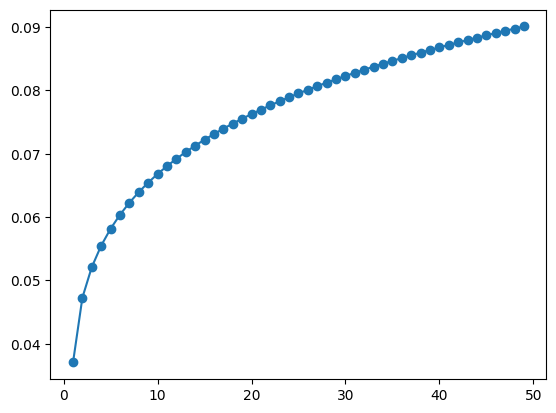

In [17]:
# Hazard function
c = np.exp(Model.params[0])
lmbda = np.exp(Model.params[1])
t = np.arange(1,50)
Ft = spst.weibull_min.cdf(x=t, c=c, scale=lmbda**(-1/c))
Ftm1 = spst.weibull_min.cdf(x=t-1, c=c, scale=lmbda**(-1/c))
hazard = (Ft-Ftm1)/(1-Ftm1)

plt.plot(t, hazard, marker='o')
plt.show()

As Hazard function shows the probability for an event to occur within some interval, we can find with what we got that in ther first few years of marriage, the hazard function increase relativaly fast, which indicates an increasing risk of divorce at the beginning of marriage. However, after decades, the incerase of Hazard function tends to slow down and decrease, indicating marriage gets stable in long term (likelihood of divorce also gets stable). 

# Part 3 [6 pts]

Now let's estimate a Weibull-Gamma model by regressing **time** on **highedu** and **race**. As in Part 1, you will need to write a custom `GenericLikelihoodModel` and use appropriate likelihoods for data that are either interval- or right-censored. Show a model summary with renamed parameters when done.

In [18]:
class WeibullGamma(GenericLikelihoodModel):
    def loglike(self, params):
        t, X = self.endog, self.exog
        divorce = X[:,0]
        c, alpha, gamma = np.exp(params[0:3])
        alpha = alpha / np.exp(X[:,1:]@params[3:])

        Ft = 1 - (alpha/(alpha+t**c))**gamma
        Ftm1 = 1 - (alpha/(alpha+(t-1)**c))**gamma
        likelihood = (Ft-Ftm1)*divorce + (1-Ft)*(1-divorce)
        return np.sum(np.log(likelihood))

In [19]:
Model = WeibullGamma(marriage["time"], marriage[["divorce", 'highedu', 'race']].values).fit(start_params=-np.random.random(5), method="bfgs")
Model.summary(xname=["log_c", "log_alpha", "log_gamma", "highedu","race"])

Optimization terminated successfully.
         Current function value: 1.525171
         Iterations: 32
         Function evaluations: 34
         Gradient evaluations: 34


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:2742: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:2746: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


<class 'statsmodels.iolib.summary.Summary'>
"""
                             WeibullGamma Results                             
==============================================================================
Dep. Variable:                   time   Log-Likelihood:                -4880.5
Model:                   WeibullGamma   AIC:                             9769.
Method:            Maximum Likelihood   BIC:                             9793.
Date:                Mon, 11 Nov 2024                                         
Time:                        15:15:50                                         
No. Observations:                3200                                         
Df Residuals:                    3197                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_c          0.4105      0.061      6.723      0.000       0.291       0.530
log_alpha      2.7088      0.126     21.478      0.000       2.462       2.956
log_gamma     -1.6060      0.133    -12.095      0.000      -1.866      -1.346
highedu       -0.5449      0.190     -2.872      0.004      -0.917      -0.173
race           0.3606      0.150      2.398      0.016       0.066       0.655
==============================================================================
"""

# Part 4 [8 pts]

Consider a couple with **race** $=1$ and **highedu** $=1$. Using your estimated model, answer the following questions or complete the following tasks:

* Generate line plots with circular markers at yearly intervals, over the range 1 to 50, showing the PDF and hazard function of the estimated model.

* Compute the marginal probability of the couple divorcing in the first half of their 4th year of marriage. Compute the conditional probability of the same event, given that they did not divorce by the beginning of their 4th year.

* Suppose this couple divorced during year 2, but later remarried. Generate the posterior distributions of the PDF and hazard function of divorce time for this new marriage.

* Compute again the marginal and conditional probabilities of the couple divorcing in the first half of their 4th year of marriage.


In [21]:
# interval likelihoods / probabilities
x = np.array([1,1])
t = np.arange(1,50)

c, alpha, gamma = np.exp(Model.params[0:3])
alpha = alpha / np.exp(x@Model.params[3:])

print(c, gamma, alpha)

1.507579749141238 0.20068342288510735 18.049278838156575


In [22]:
Ft = 1 - (alpha/(alpha+t**c))**gamma
Ftm1 = 1 - (alpha/(alpha+(t-1)**c))**gamma
likelihood = Ft-Ftm1
hazard = (Ft-Ftm1)/(1-Ftm1)

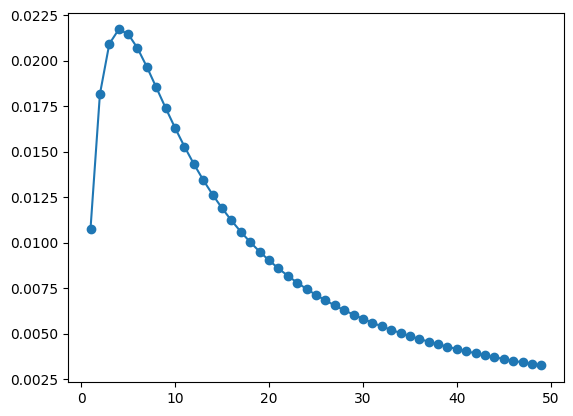

In [23]:
plt.plot(t, likelihood, marker='o')
plt.show()

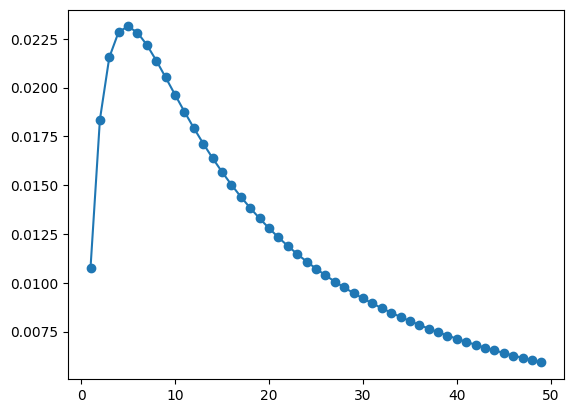

In [24]:
# interval-censored hazard
plt.plot(t, hazard, marker='o')
plt.show()

In [25]:
# P(divorce in first half of year 4) = P(divorce between 3 and 3.5)
Pdivorce = (1 - (alpha/(alpha+3.5**c))**gamma) - (1 - (alpha/(alpha+3**c))**gamma)
Pdivorce

0.010842912073650068

In [26]:
# P(divorce between 3 and 3.5 | no divorce up to 3)
Pdivorce / (1 - (1 - (alpha/(alpha+3**c))**gamma))

0.01141193628073445

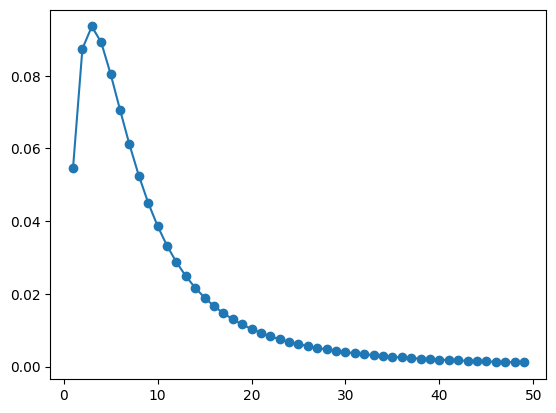

In [27]:
gamma += 1
alpha += 2**c

Ft = 1 - (alpha/(alpha+t**c))**gamma
Ftm1 = 1 - (alpha/(alpha+(t-1)**c))**gamma
likelihood = Ft-Ftm1
hazard = (Ft-Ftm1)/(1-Ftm1)

plt.plot(t, likelihood, marker='o')
plt.show()

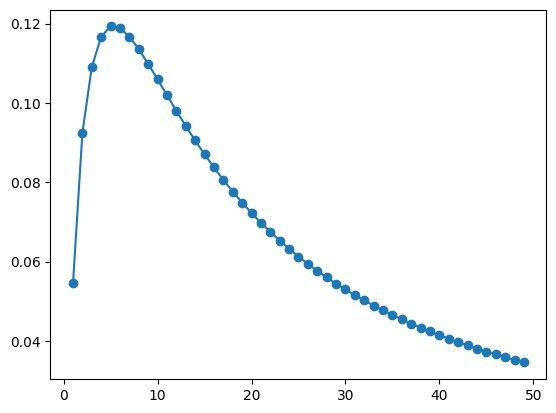

In [28]:
plt.plot(t, hazard, marker='o')
plt.show()

In [29]:
# P(divorce between 3 and 3.5)
Pdivorce = (1 - (alpha/(alpha+3.5**c))**gamma) - (1 - (alpha/(alpha+3**c))**gamma)
Pdivorce

0.04551136399198963

In [30]:
# P(divorce between 3 and 3.5 | no divorce up to 3)
Pdivorce / (1 - (1 - (alpha/(alpha+3**c))**gamma))

0.059539676859601785